# Проект по анализу данных с сайта ОСН (Общественная служба новостей)

## Часть 1.1
## Реализация парсера

In [12]:
import requests
import re
import time
import datetime
import pandas as pd
import time
import numpy as np


#from google.colab import files
from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from dataclasses import dataclass

In [13]:
SLEEP = 3
BASE_URL = 'https://www.osnmedia.ru/'
TOPICS = ['politika', 'obshhestvo', 'ekonomika','proisshestviya', 'world', 'sport', 'kultura', 'exclusive']

In [14]:
# set webdriver params
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('headless')
chrome_options.add_argument('no-sandbox')
chrome_options.add_argument('disable-dev-shm-usage')
driver = webdriver.Chrome(options=chrome_options)

In [5]:
%pip install fake_useragent

In [18]:
from fake_useragent import UserAgent
ua = UserAgent(browsers=['edge', 'chrome', 'ff', 'firefox', 'safari'])

In [19]:
response = requests.get(BASE_URL , headers={'User-Agent': ua.random})
tree = BeautifulSoup(response.content, 'html.parser')
response

<Response [200]>

In [21]:
def checkIP():
    ip = requests.get('http://checkip.dyndns.org').content
    soup = BeautifulSoup(ip, 'html.parser')
    print(soup.find('body').text)

checkIP()

Current IP Address: 188.170.73.206


In [22]:
@dataclass
class Article:
    url: str = None
    title: str = None
    topic: str = None
    content: str = None
    datetime: str = None

In [23]:
def get_pages(p):
  """Load certain page in chosen topics"""
  items = []

  for topic in tqdm(TOPICS):
      URL = BASE_URL + 'category/' + topic + f'/page/{p}'
      driver.get(URL)
      time.sleep(SLEEP)

      html = driver.page_source
      soup = BeautifulSoup(html, "html.parser")
      items += soup.find_all('div', {'class': 'category-news-block'})

  return items

In [24]:
def parse_page(page):
  """In ever article parse url, title, """
  article = Article()

  article.url = page.a.get('href')

  # load page
  driver.get(article.url)
  time.sleep(SLEEP)
  html = driver.page_source

  # article object
  soup = BeautifulSoup(html, "html.parser")
  obj = soup.find('div', {'class': 'postContent'})

  # process article title
  try:
    title = obj.find('h1', {'class': 'page-title'})
    article.title = title.text
  except AttributeError:
    pass

  # article topic
  try:
    topic = obj.find('h2', {'class': 'section-header'})
    article.topic = topic.text
  except AttributeError:
    pass

  # article content
  article.content = obj.find('div', {'class': 'maintext'}).text

  # article datetime
  article.datetime = obj.find('span', {'class': 'superdate'}).text

  return article

In [65]:
itemz = []

In [ ]:
for p in range(1,100):
  itemz.extend(get_pages(p))

100%|██████████| 8/8 [00:28<00:00,  3.56s/it]


In [69]:
len(itemz)

6860

In [29]:
data = []
count = 0

for num, page in enumerate(tqdm(itemz)):
    count += 1
    res = parse_page(page)
    data.append(res)

    if count % 10 == 0:
        df = pd.DataFrame(data)
        df.to_csv('c://Users/User/Downloads/articles_osn.csv', index=False)

100%|██████████| 280/280 [1:07:53<00:00, 14.55s/it]


In [30]:
data[:2]

[Article(url='https://www.osnmedia.ru/?post_type=post&p=1485496', title='Кремль: Резонансность уголовных дел не влияет на возможность помилования', topic='\n\nПолитика\n', content='  15 ноября 2023, 12:41 — Общественная служба новостей — ОСН Пресс-секретарь президента России Дмитрий Песков в среду, 15 ноября, в ходе брифинга с журналистами прокомментировал помилование осужденных по громким уголовным делам за участие в спецоперации.Официальный представитель Кремля заявил, что резонансность уголовных дел не влияет на возможность помилования участников СВО.  «Существует определенная практика, которая реализуется, и, насколько мне известно, в этой практике никаких исключений нет. Точнее, есть исключения, но они не касаются темы резонансности того или иного дела», — пояснил Песков.Ранее адвокат Сергея Хаджикурбанова, осужденного за организацию убийства журналистки Анны Политковской, сообщил, что его подзащитный принял участие в Специальной Военной Операции (СВО) и был помилован. Подробнее о

## Часть 1.2
## Подготовка и первичный анализ данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В данном шаге нам необходимо провести основные описательные статистики + визуальный анализ данных. Важно отметить интересные моменты в наших данных до проведения исследования:
- определить особенности выборки по результатам первичного анализ, удаление выбросов и т.д.
- отметить моменты, которые позволят до проведения расчетов и построения моделей, выдвинуть несколько гипотез/предположений о результатах следующих этапов и т.д.
---
Также необходимо сделать:

- Очистку текстов от ненужных элементов
- Приведение столбца 'datetime' к формату даты
- Распределение по разделам
- Распределение времени новостей
- Распределение по длине заголовка
- Распределение по длине текста
- Ключевые слова по каждой из тематик

In [61]:
df = pd.read_csv('c://Users/User/Downloads/articles_osn.csv').drop(['Unnamed: 0'],axis=1)

In [62]:
df.tail(3)

url  \
13517  https://www.osnmedia.ru/?post_type=post&p=1469270   
13518  https://www.osnmedia.ru/?post_type=post&p=1469266   
13519  https://www.osnmedia.ru/?post_type=post&p=1469262   

                                                   title         topic  \
13517  País: В ВСУ объяснили остановку контрнаступлен...  \n\nВ мире\n   
13518  Al Arabiya: ЦАХАЛ атакует административный цен...  \n\nВ мире\n   
13519  TI: Египет разместил десятки танков и бронемаш...  \n\nВ мире\n   

                                                 content  \
13517    1 ноября 2023, 03:16 — Общественная служба н...   
13518    1 ноября 2023, 02:50 — Общественная служба н...   
13519    1 ноября 2023, 02:36 — Общественная служба н...   

                                                datetime  
13517  1 ноября 2023, 03:16 — Общественная служба нов...  
13518  1 ноября 2023, 02:50 — Общественная служба нов...  
13519  1 ноября 2023, 02:36 — Общественная служба нов...

Для начала мы очистим тексты статей из признака `content` от даты, а из самого признака с датой уберём строку " - Общественная служба новостей".

In [63]:
for i in range(len(df)):
      df['content'][i] = df['content'][i].replace(str(df['datetime'][i]), '')
      df['datetime'][i] = df['datetime'][i].replace(' — Общественная служба новостей — ОСН ', '')

Для удобства работы, мы уберём из названий разделов символы переноса строки '\n'.

In [64]:
df['topic'] = df['topic'].str.replace('\n', '')

In [65]:
df.topic.value_counts()

topic
Общество        3119
Политика        1838
Экономика       1725
Происшествия    1704
В мире          1687
Спорт           1677
Культура        1671
Эксклюзив         94
Главное            2
Картина дня        2
Безопасность       1
Name: count, dtype: int64

C:\Users\User\AppData\Local\Temp\ipykernel_7748\3986827379.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['topic'], palette='tab10', ax=ax)


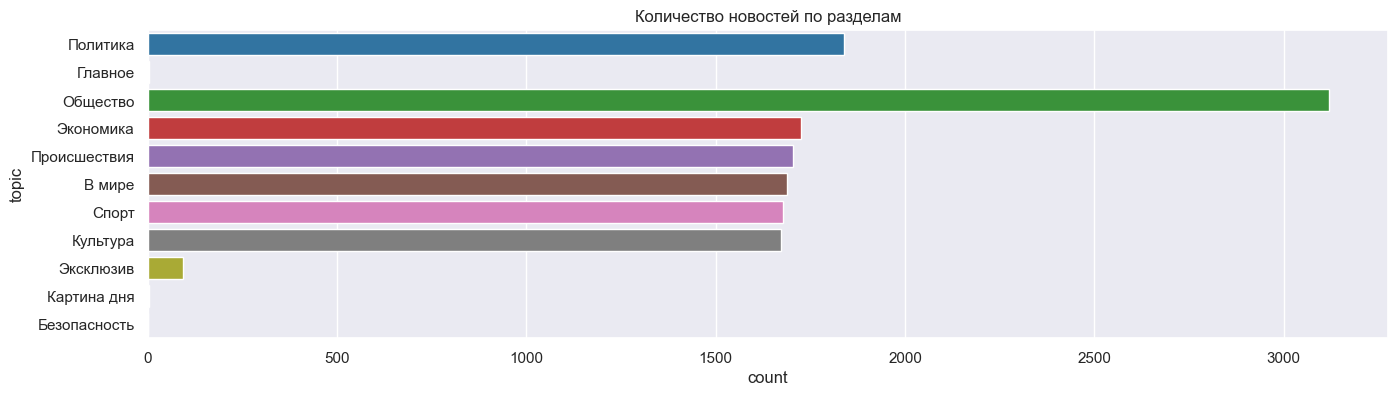

In [66]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,4))
sns.countplot(y=df['topic'], palette='tab10', ax=ax)
plt.title('Количество новостей по разделам');

Мы видим, что в разделах "Картина дня", "Безопасность" и "Главное" всего по 1 и 2 статьи.  В разделе "Эксклюзив" тоже всего 94 статьи. Избавимся от этих разделов, так как они составляют менее 1% от датасета и усложнят работу задачи классификации.

In [67]:
df = df.loc[~df.topic.isin(['Безопасность', 'Картина дня', 'Главное', 'Эксклюзив'])]

In [68]:
df.topic.value_counts()

topic
Общество        3119
Политика        1838
Экономика       1725
Происшествия    1704
В мире          1687
Спорт           1677
Культура        1671
Name: count, dtype: int64

Мы видим, что больше всего статей в разделе "Общество" - почти в два раза больше, чем в любом другом разделе. Остальные разделы примерно одинаковы по размерам.

Приведём признак с датой к формату 'datetime'

In [69]:
def replace_date_string(date_string):
  date_format = '%d %B %Y, %H:%M'
  month_names = {
      'января': 'January',
      'февраля': 'February',
      'марта': 'March',
      'апреля': 'April',
      'мая': 'May',
      'июня': 'June',
      'июля': 'July',
      'августа': 'August',
      'сентября': 'September',
      'октября': 'October',
      'ноября': 'November',
      'декабря': 'December'
    }

  for ru_month, en_month in month_names.items():
      date_string = date_string.replace(ru_month, en_month)

  datetime_object = datetime.strptime(date_string, date_format)
  return datetime_object

In [70]:
df.datetime = df.datetime.apply(replace_date_string)

Теперь мы можем создать новые признаки с месяцом и днём недели для визуализации.

In [71]:
df['month'] = df['datetime'].dt.strftime("%B")
df['weekday'] = df['datetime'].dt.strftime('%A')

In [72]:
df.head()

url  \
0  https://www.osnmedia.ru/?post_type=post&p=1486489   
1  https://www.osnmedia.ru/?post_type=post&p=1486441   
2  https://www.osnmedia.ru/?post_type=post&p=1486397   
3  https://www.osnmedia.ru/?post_type=post&p=1486326   
4  https://www.osnmedia.ru/?post_type=post&p=1486318   

                                               title     topic  \
0  Пленный боец ВСУ Пиявка отказался от обмена и ...  Политика   
1  Глава МИД Чехии: Заморозка собственности РФ не...  Политика   
2  Экс-морпех Берлетик: Владимира Зеленского могу...  Политика   
3  Экс-депутат Рады Мосийчук*: ВС РФ нанесли удар...  Политика   
4  Россиянка Юлия Шандогли рассказала о спасении ...  Политика   

                                             content            datetime  \
0    Пленный боец Десятой горно-штурмовой бригады... 2023-11-15 23:39:00   
1    Заморозка государственной собственности Росс... 2023-11-15 22:56:00   
2    Бывший морской пехотинец ВС США Брайан Берле... 2023-11-15 22:48:00   
3    Ракетному удару со стороны российских военны... 2023-11-15 20:58:00   
4    Гражданка РФ Юлия Шандогли, которую эвакуиро... 2023-11-15 20:50:00   

      month    weekday  
0  November  Wednesday  
1  November  Wednesday  
2  November  Wednesday  
3  November  Wednesday  
4  November  Wednesday

C:\Users\User\AppData\Local\Temp\ipykernel_7748\2423820596.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)


C:\Users\User\AppData\Local\Temp\ipykernel_7748\2423820596.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)


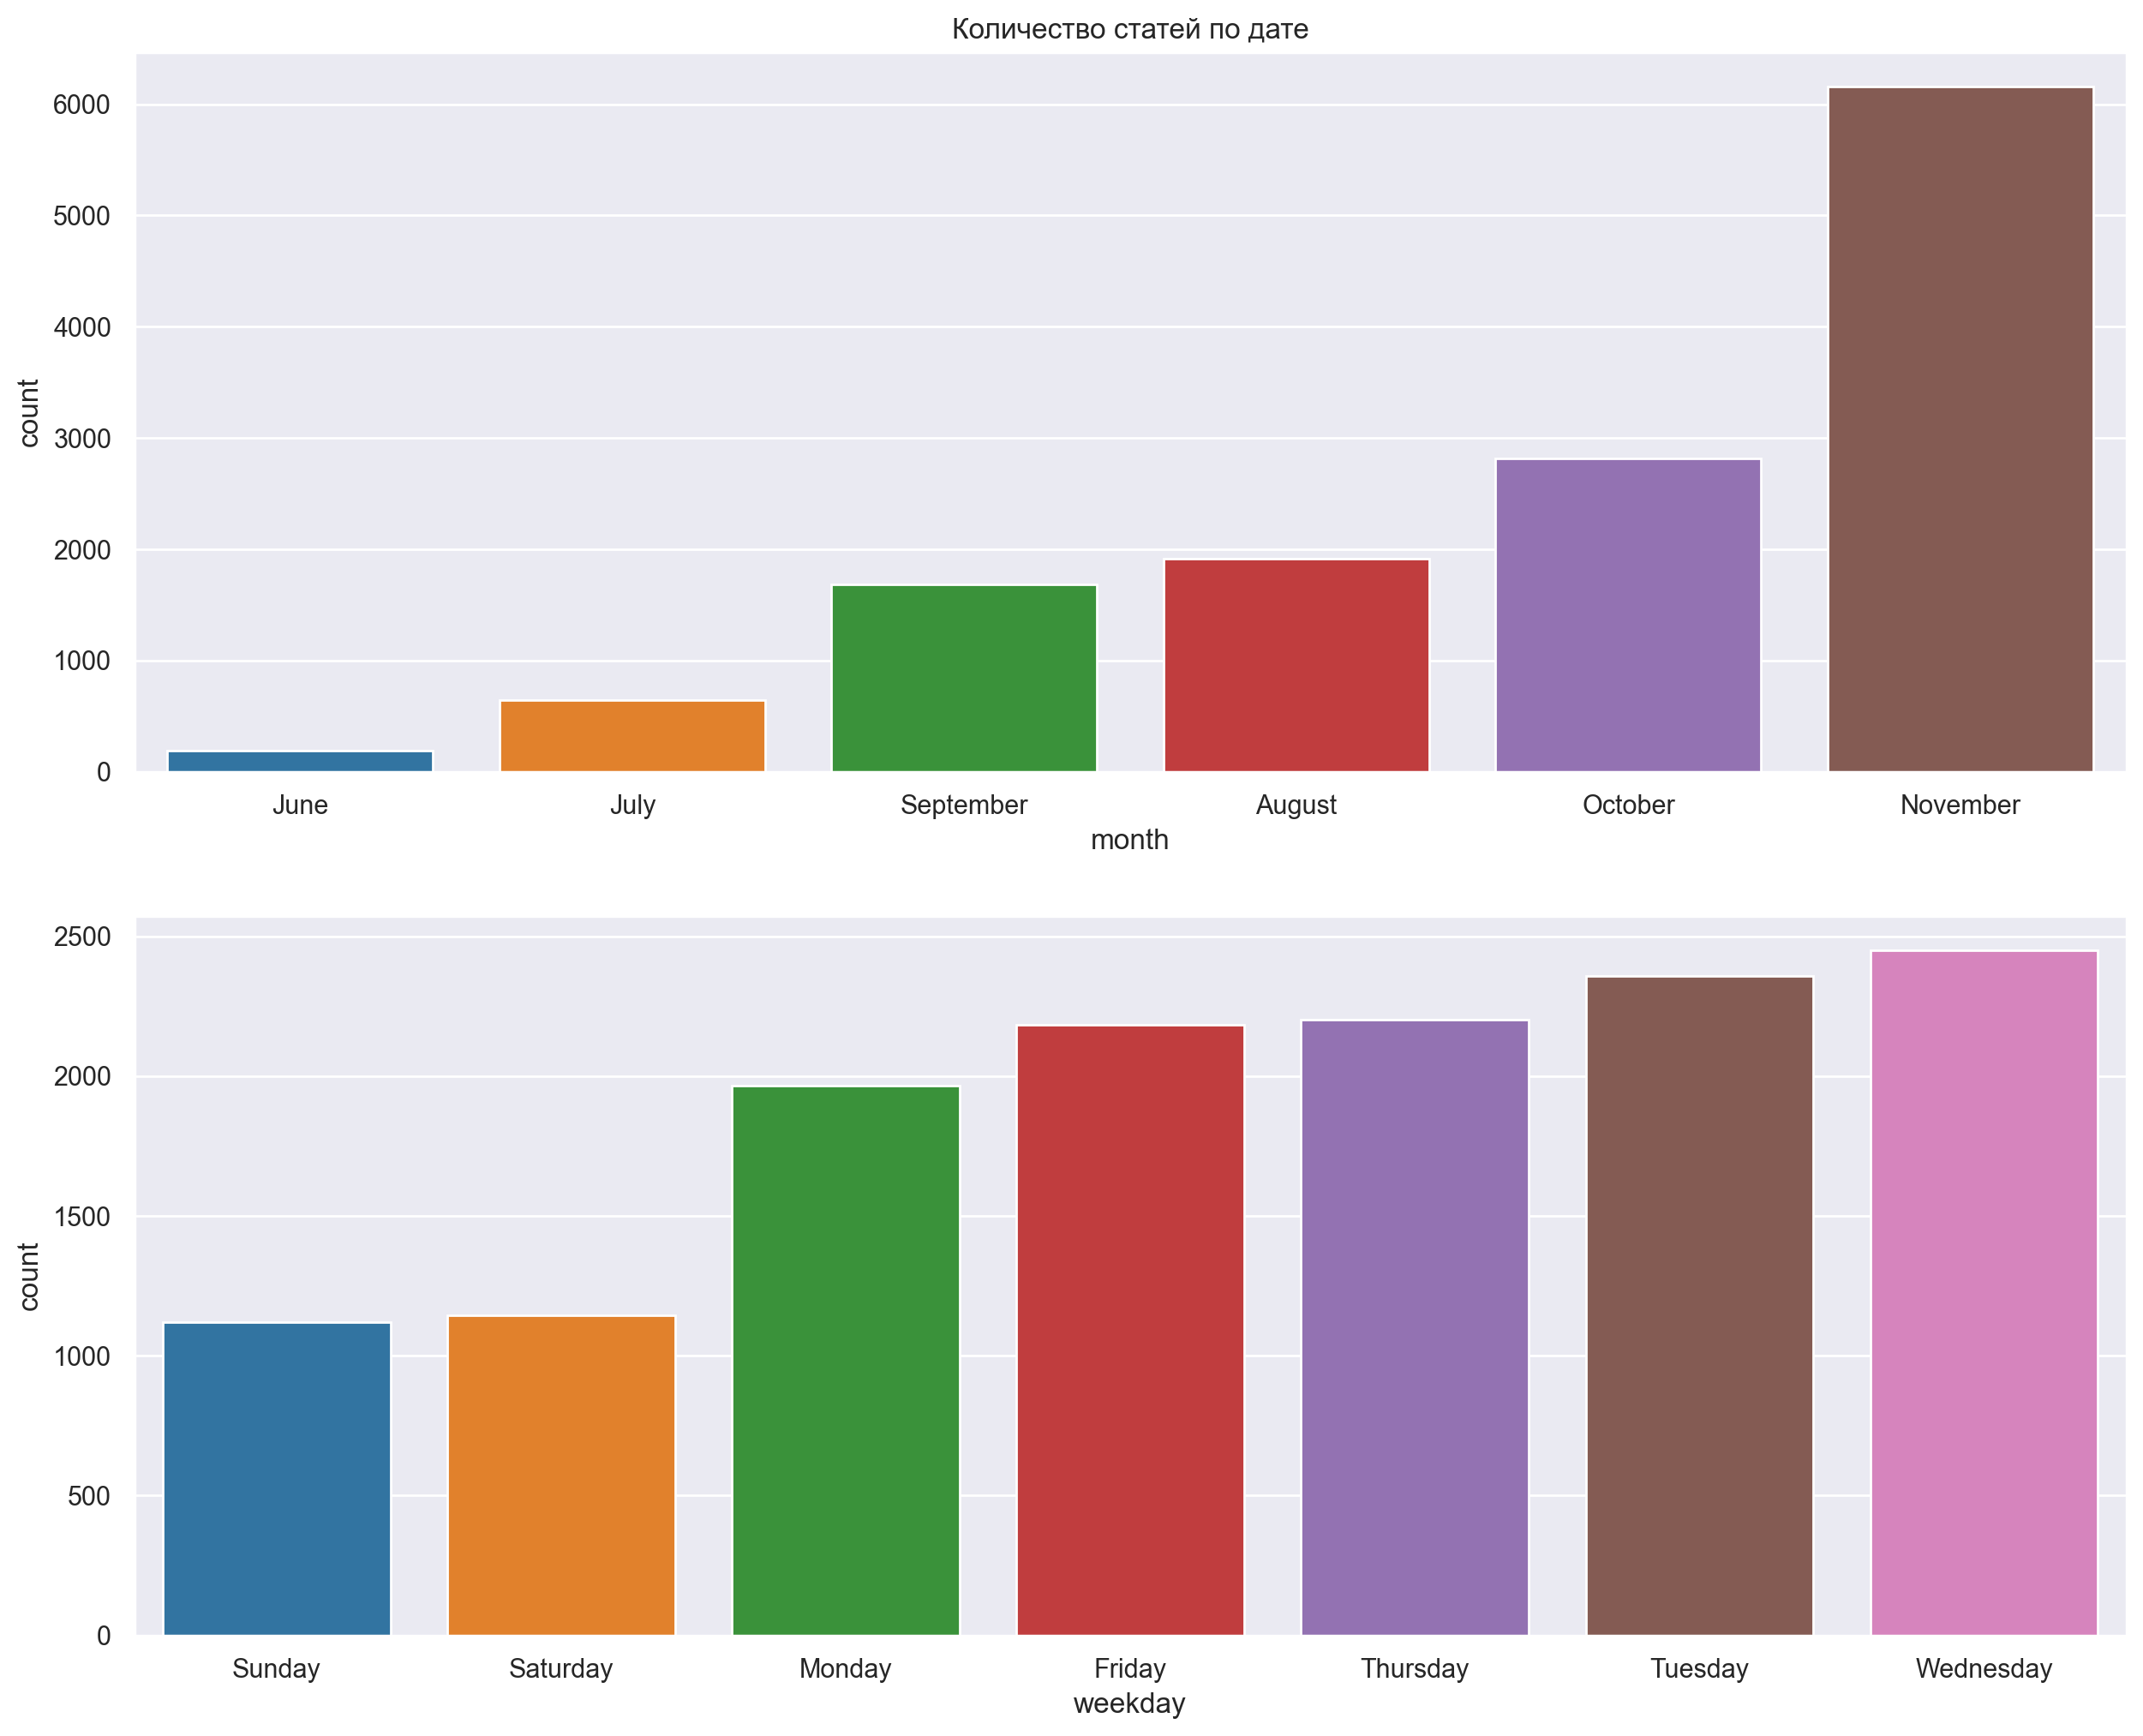

In [73]:
fig, axs = plt.subplots(2, 1, figsize=(15, 12), dpi=200)
for ind, col in enumerate(['month', 'weekday']):
    sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)
axs[0].set_title('Количество статей по дате');

Очевидным образом, больше всего статей было выпущено в ноябре, так как парсили сайт мы 16 ноября 2023 года. Интересно отметить, что больше всего новостей на сайте ОСН выпускалось во вторник и среду, а меньше всего - в выходные.

Далее добавим в таблицу признаки с длинами заголовков и содержаний. Попробуем проанализировать, каким образом в разделах различаются размеры статей.

In [86]:
df['len_title'] = df['title'].str.len()
df['len_content'] = df['content'].str.len()

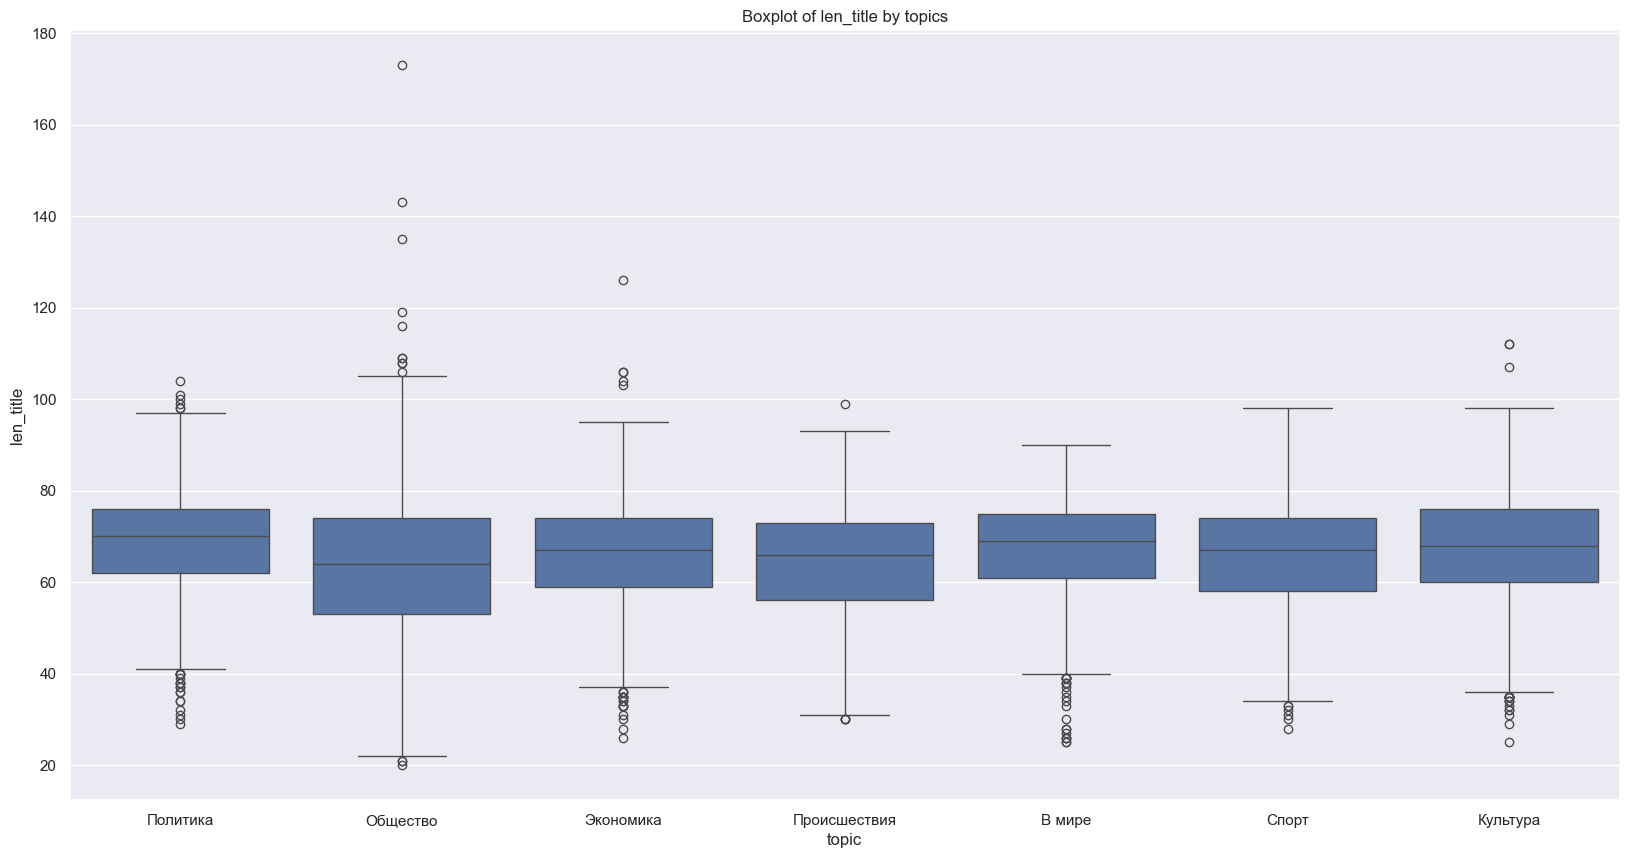

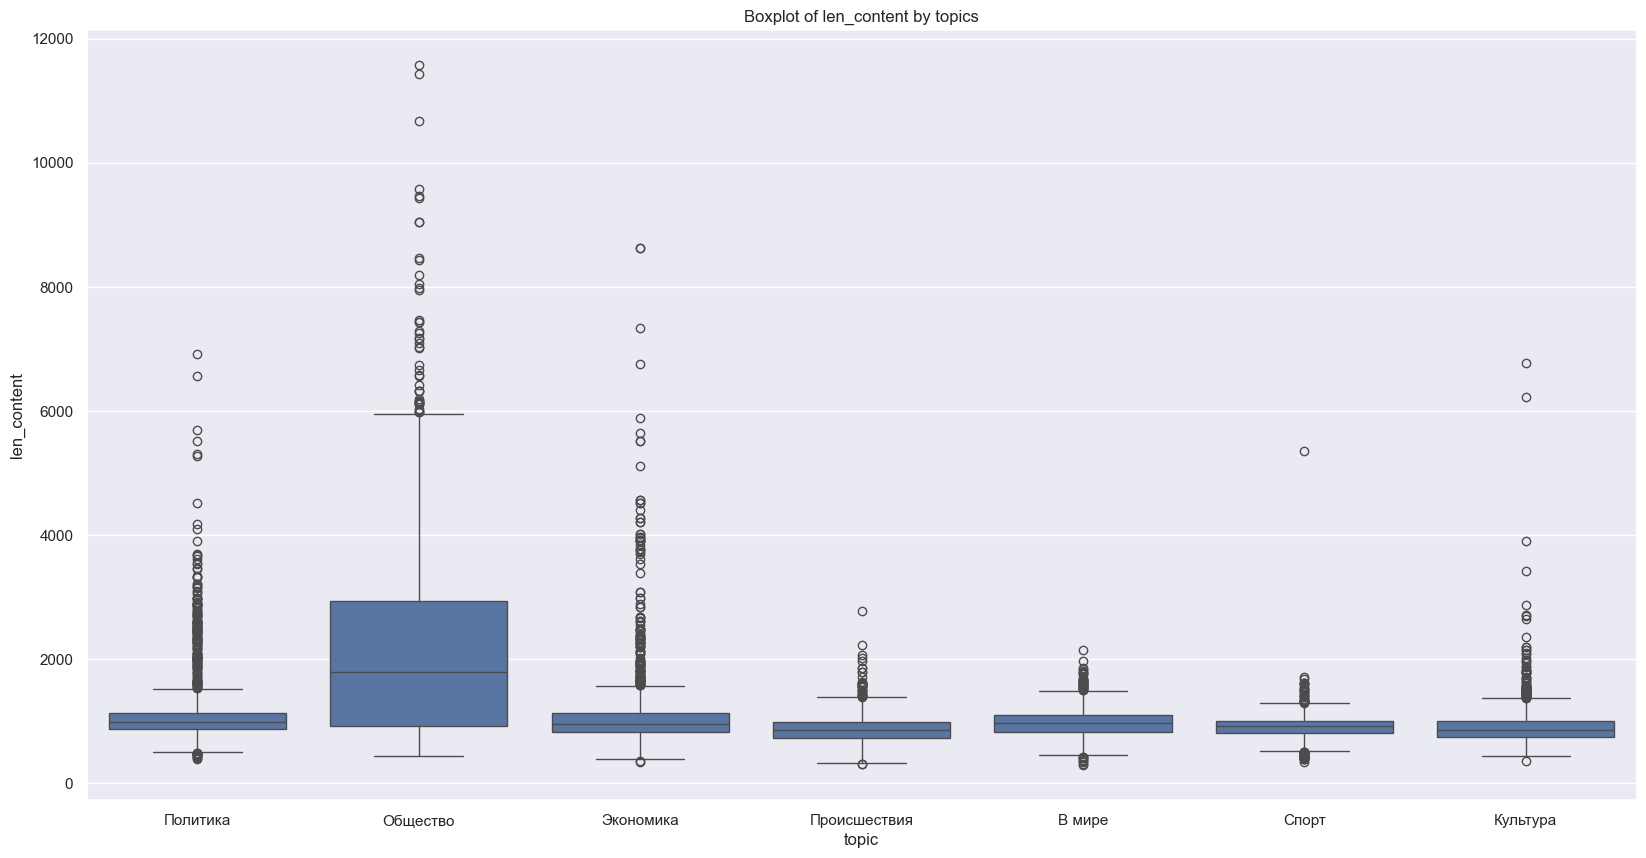

In [77]:
for col in ['len_title', 'len_content']:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=df, ax=ax)
    plt.title(f'Boxplot of {col} by topics');

In [78]:
df.drop('datetime', axis=1).describe()

len_title   len_content
count  13421.000000  13421.000000
mean      65.443857   1251.231577
std       12.397331    949.228991
min       20.000000    289.000000
25%       58.000000    810.000000
50%       67.000000    957.000000
75%       75.000000   1158.000000
max      173.000000  11573.000000

- Мы видим, что средняя длина заголовка равняется 65 знакам, а средняя длина статьи - 1251 знаков (при этом медиана - 957).
- Самыми объемными статьями оказались статьи из раздела "Общество", который содержит самое большое количество статей. Статьи из остальных разделов имеют примерно одинаковые длины статей.
- Присутствует некоторое количество выбросов в длинах заголовков.

Взглянем на то, какие ключевые слова присутствуют в заголовках каждой из тематик.

In [79]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык', 'ноября', 'делать', 'рассказал'])

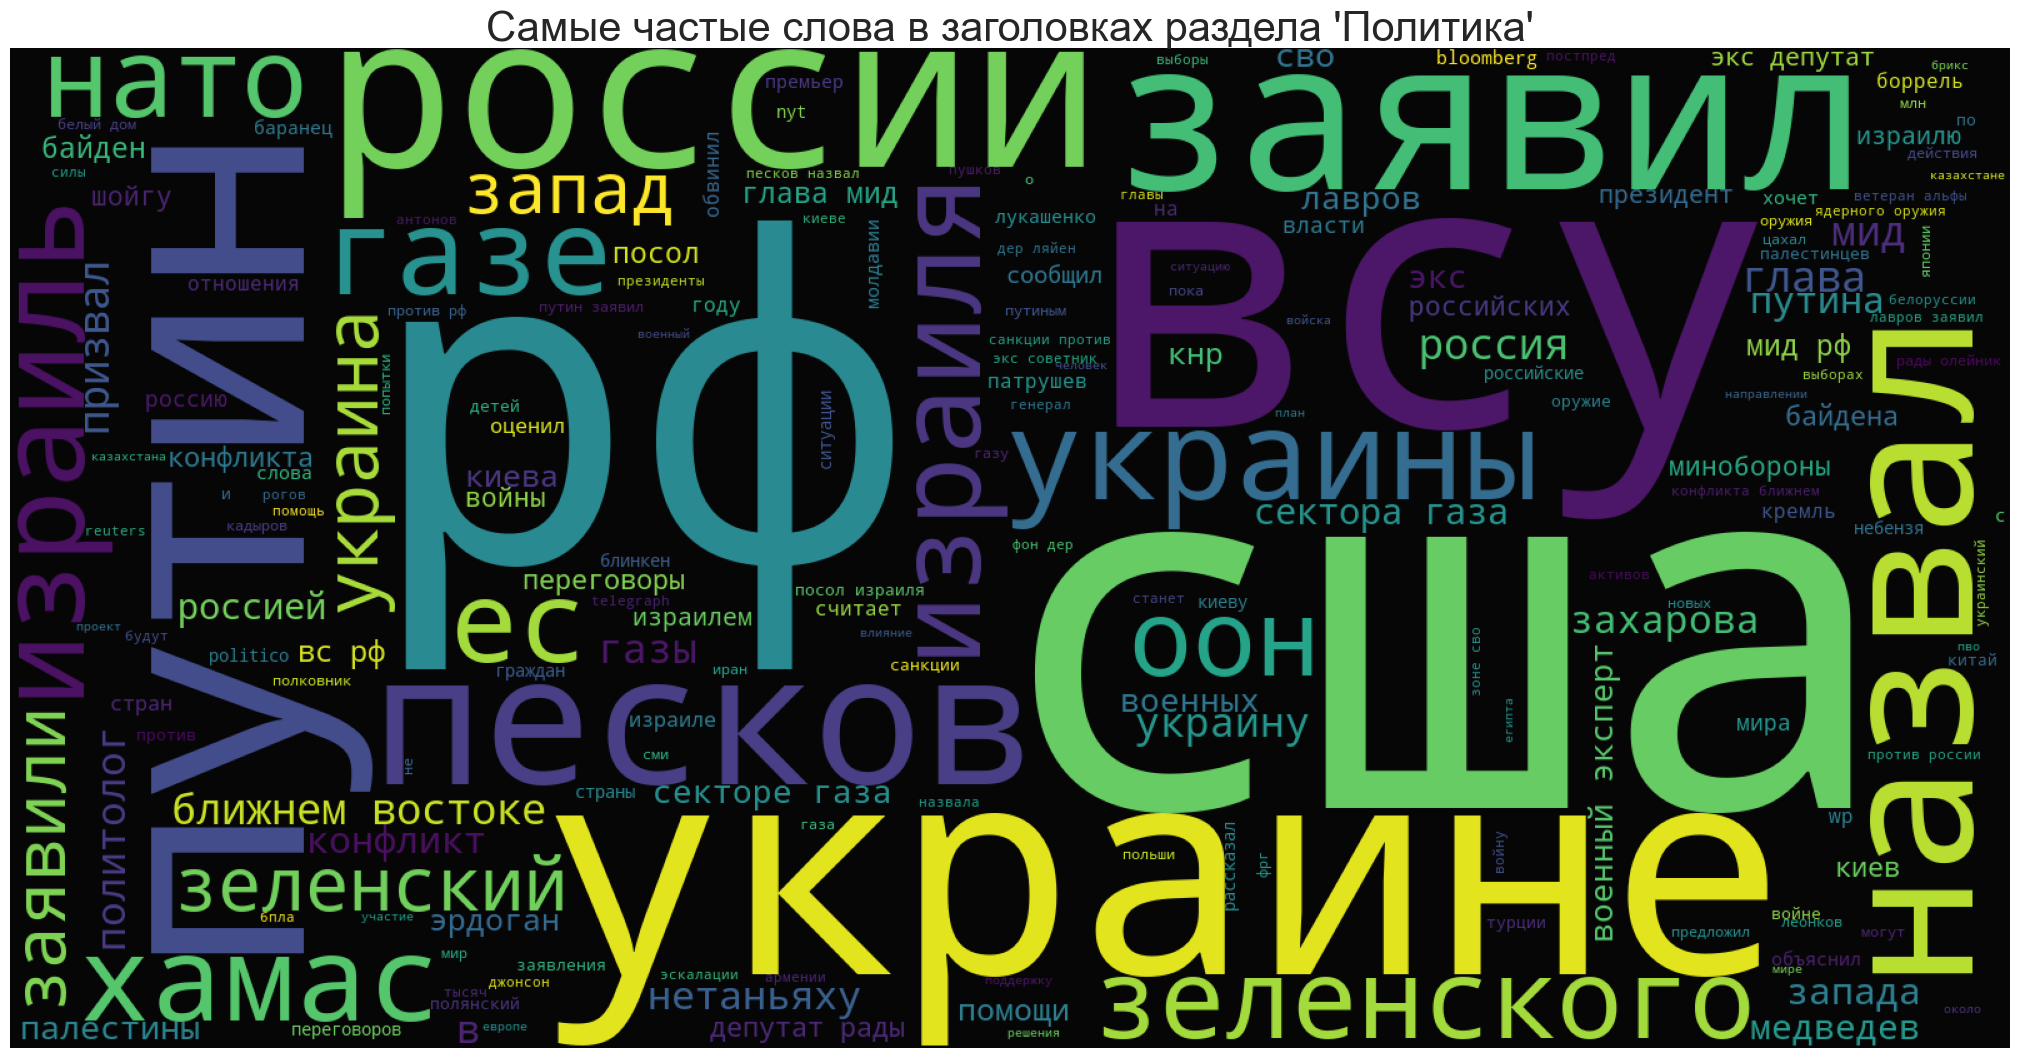

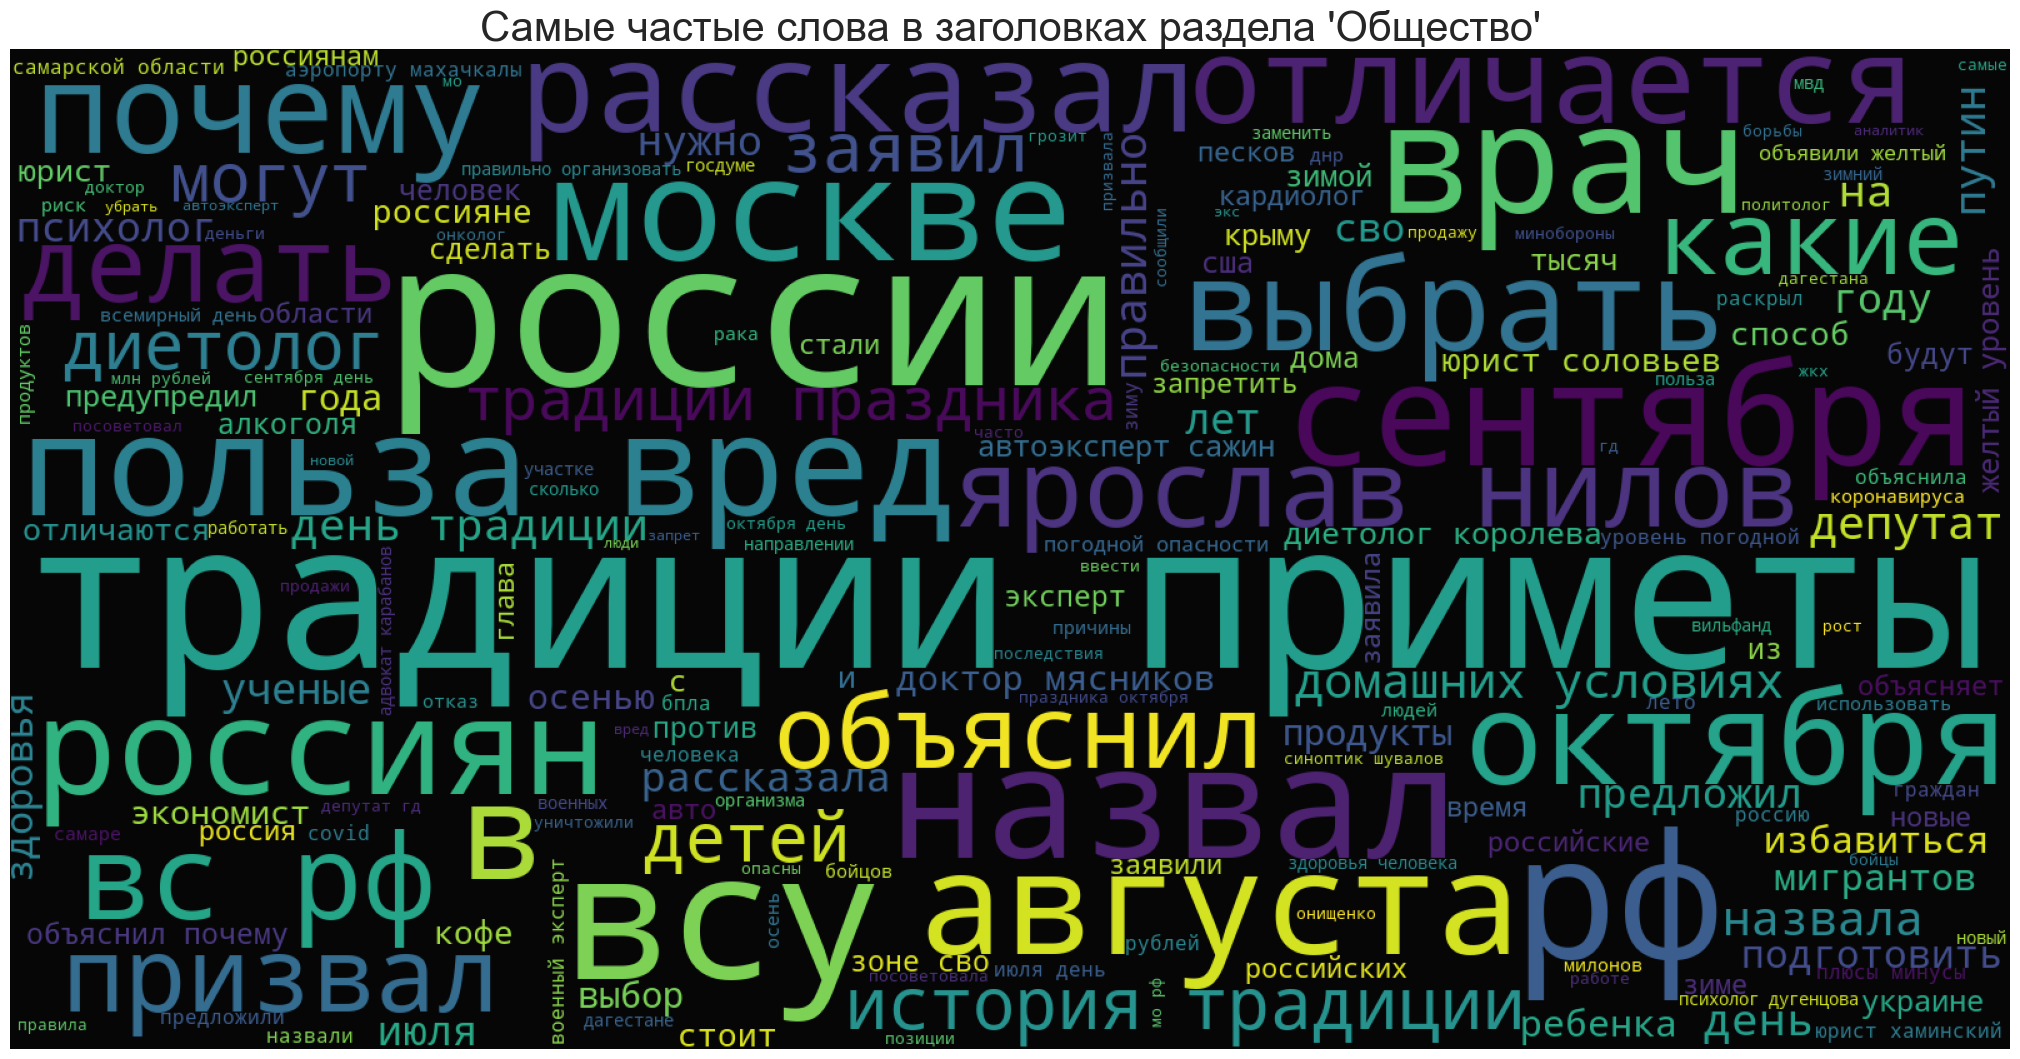

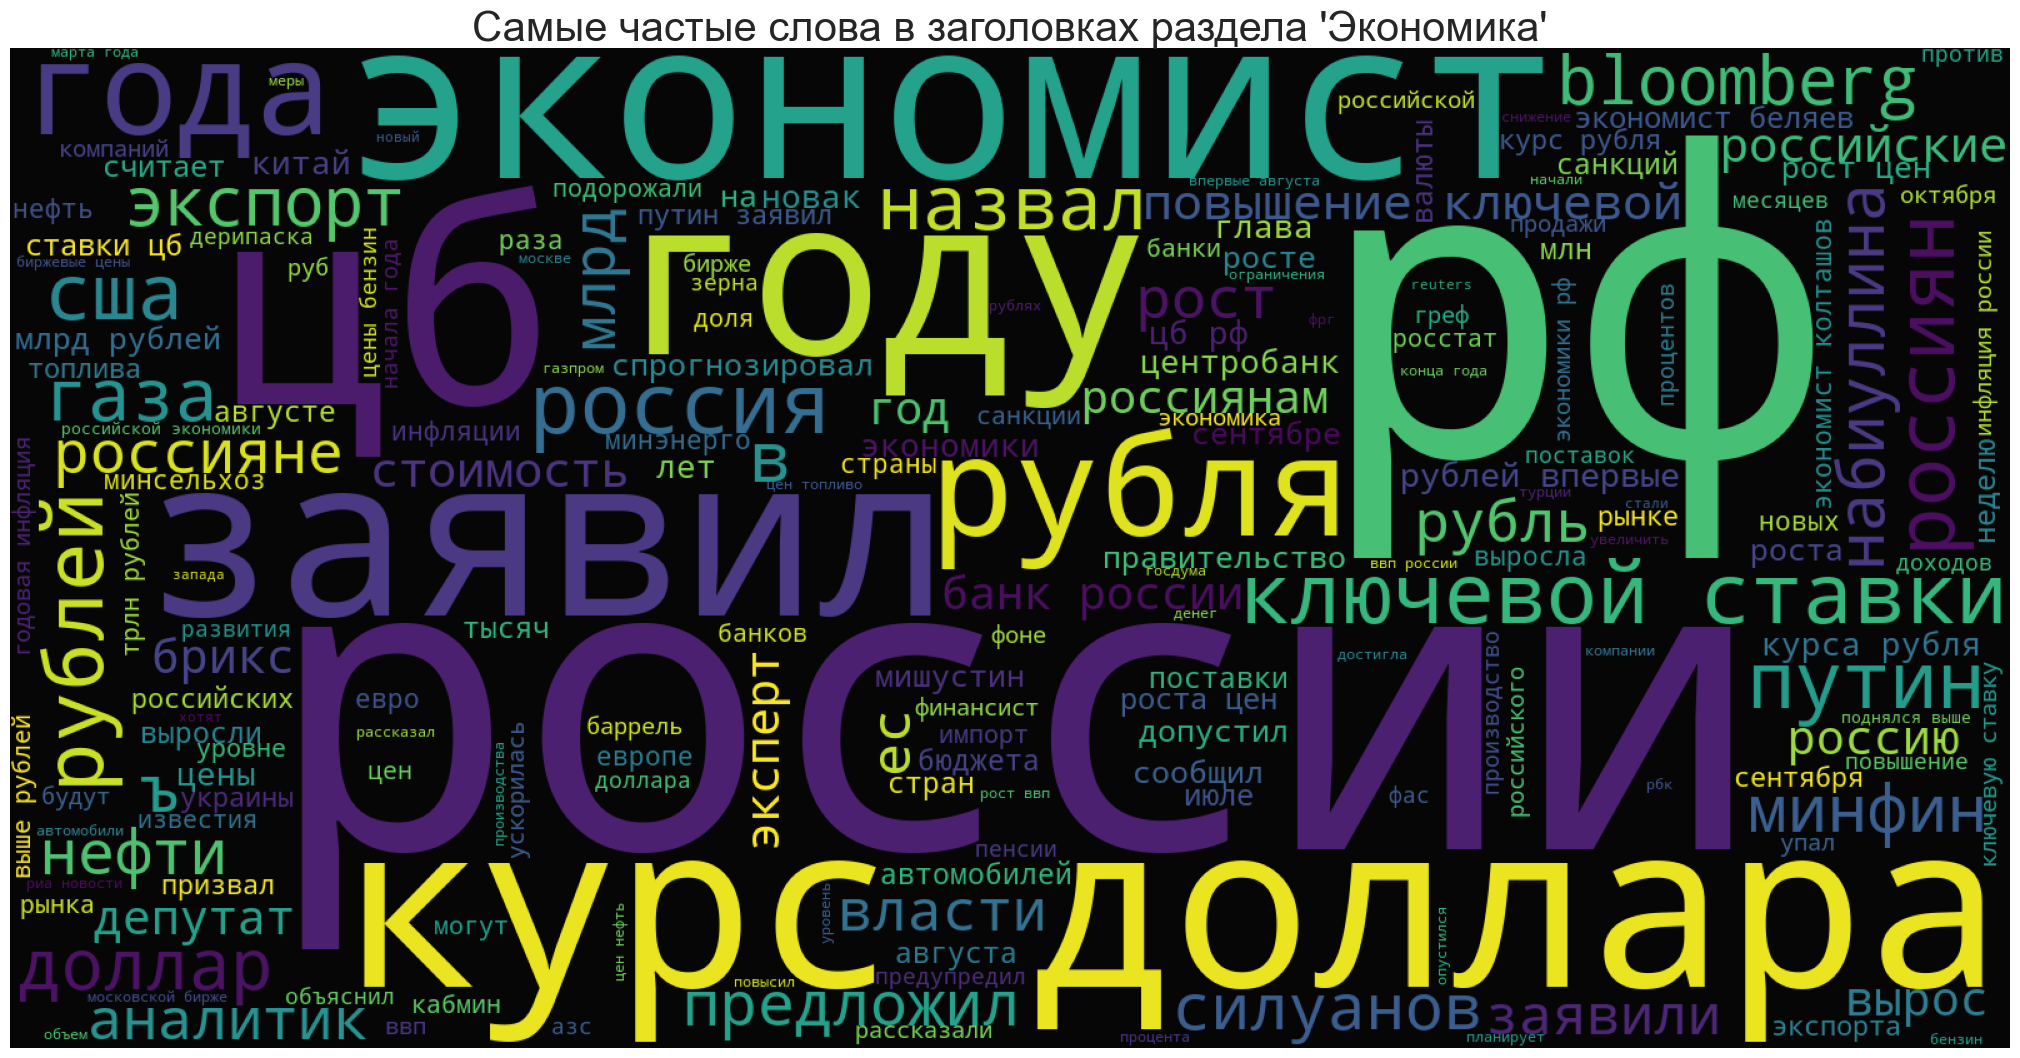

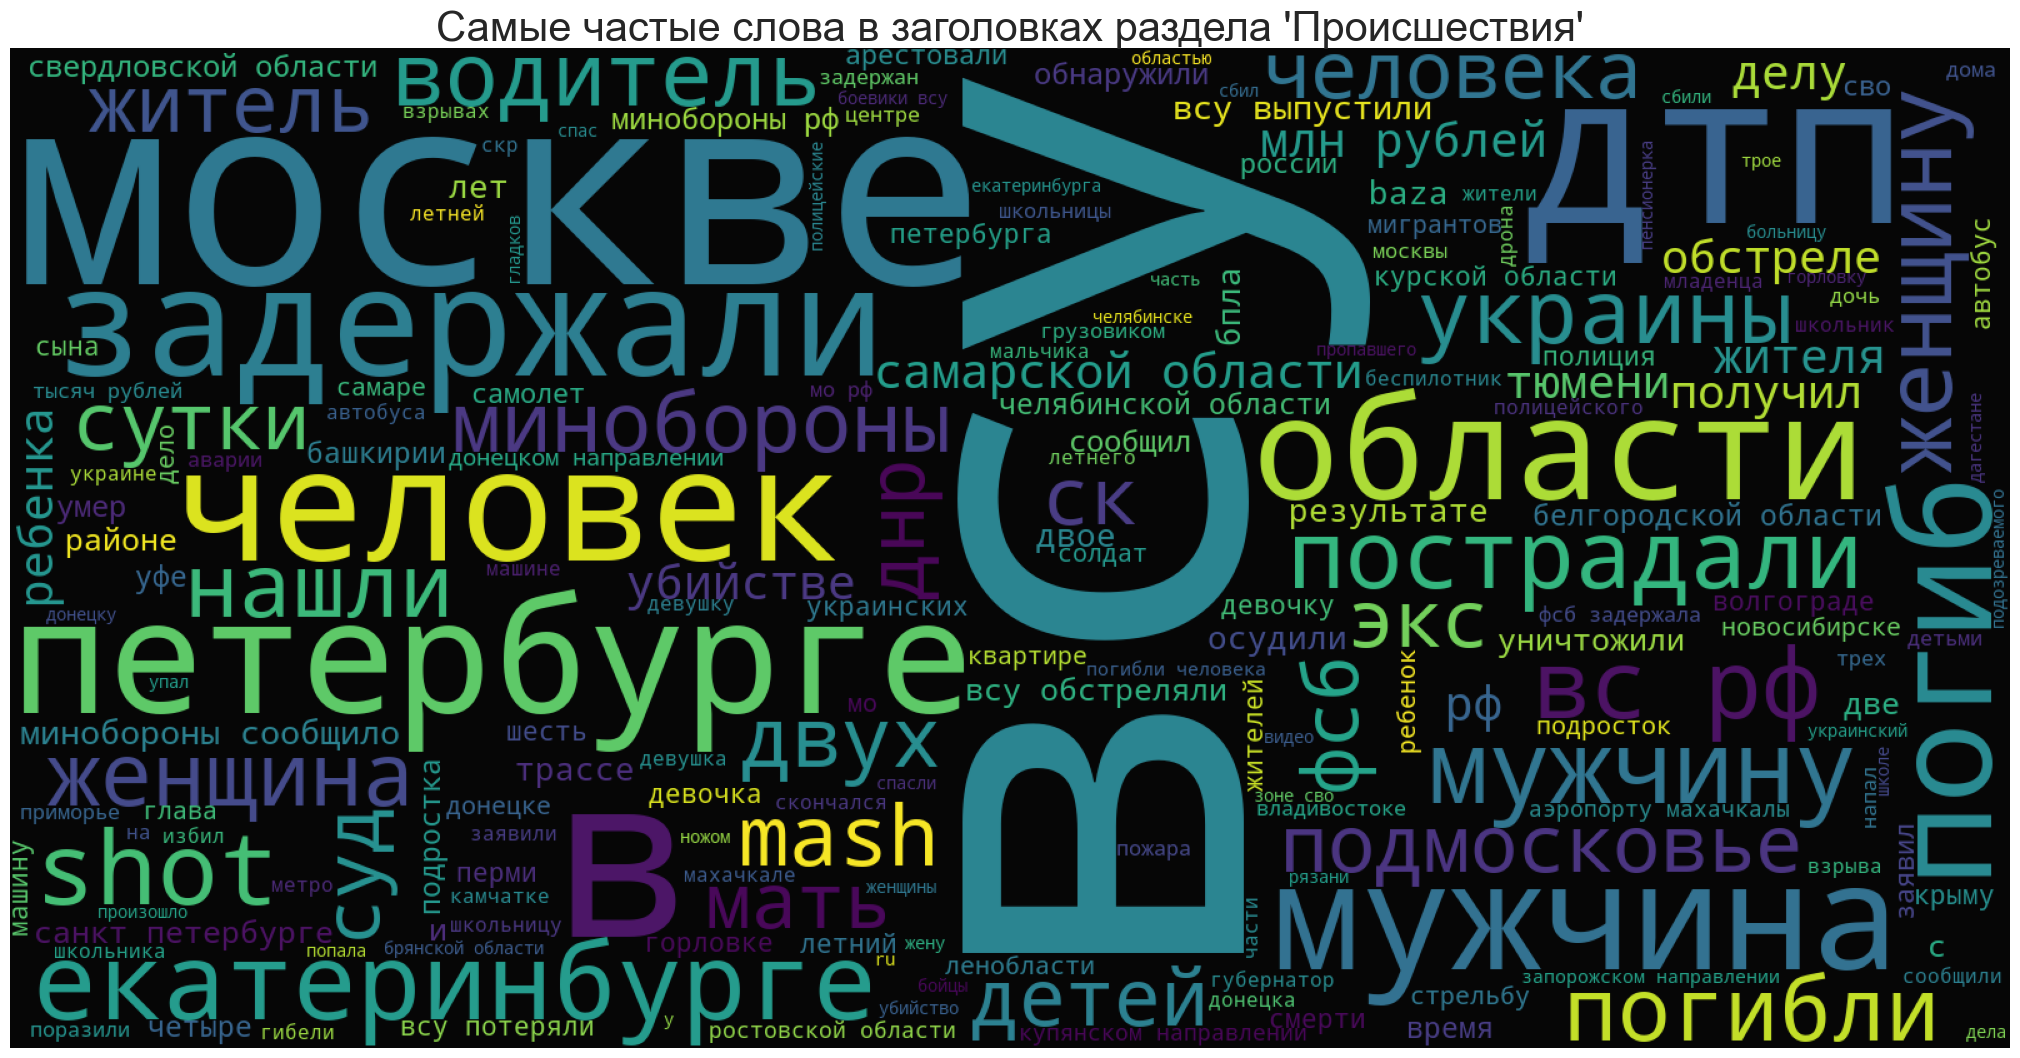

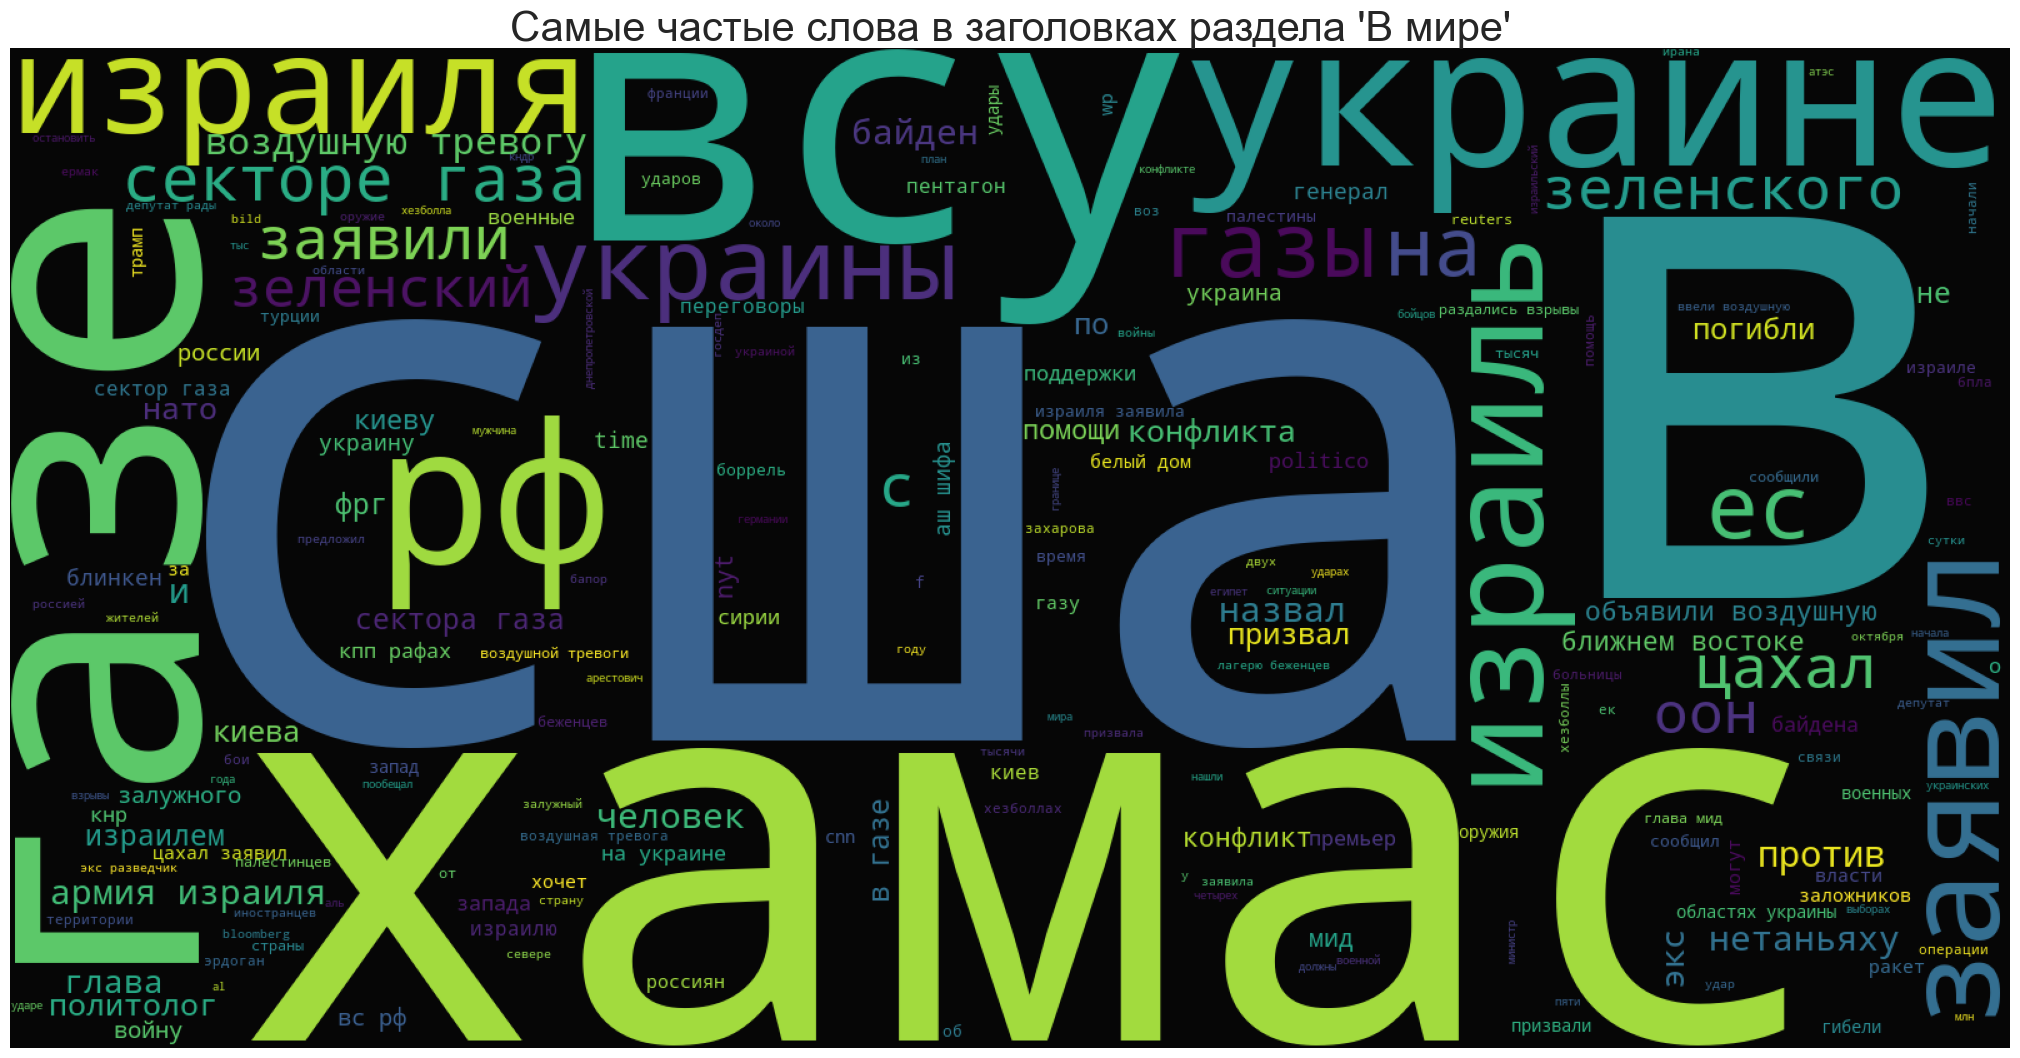

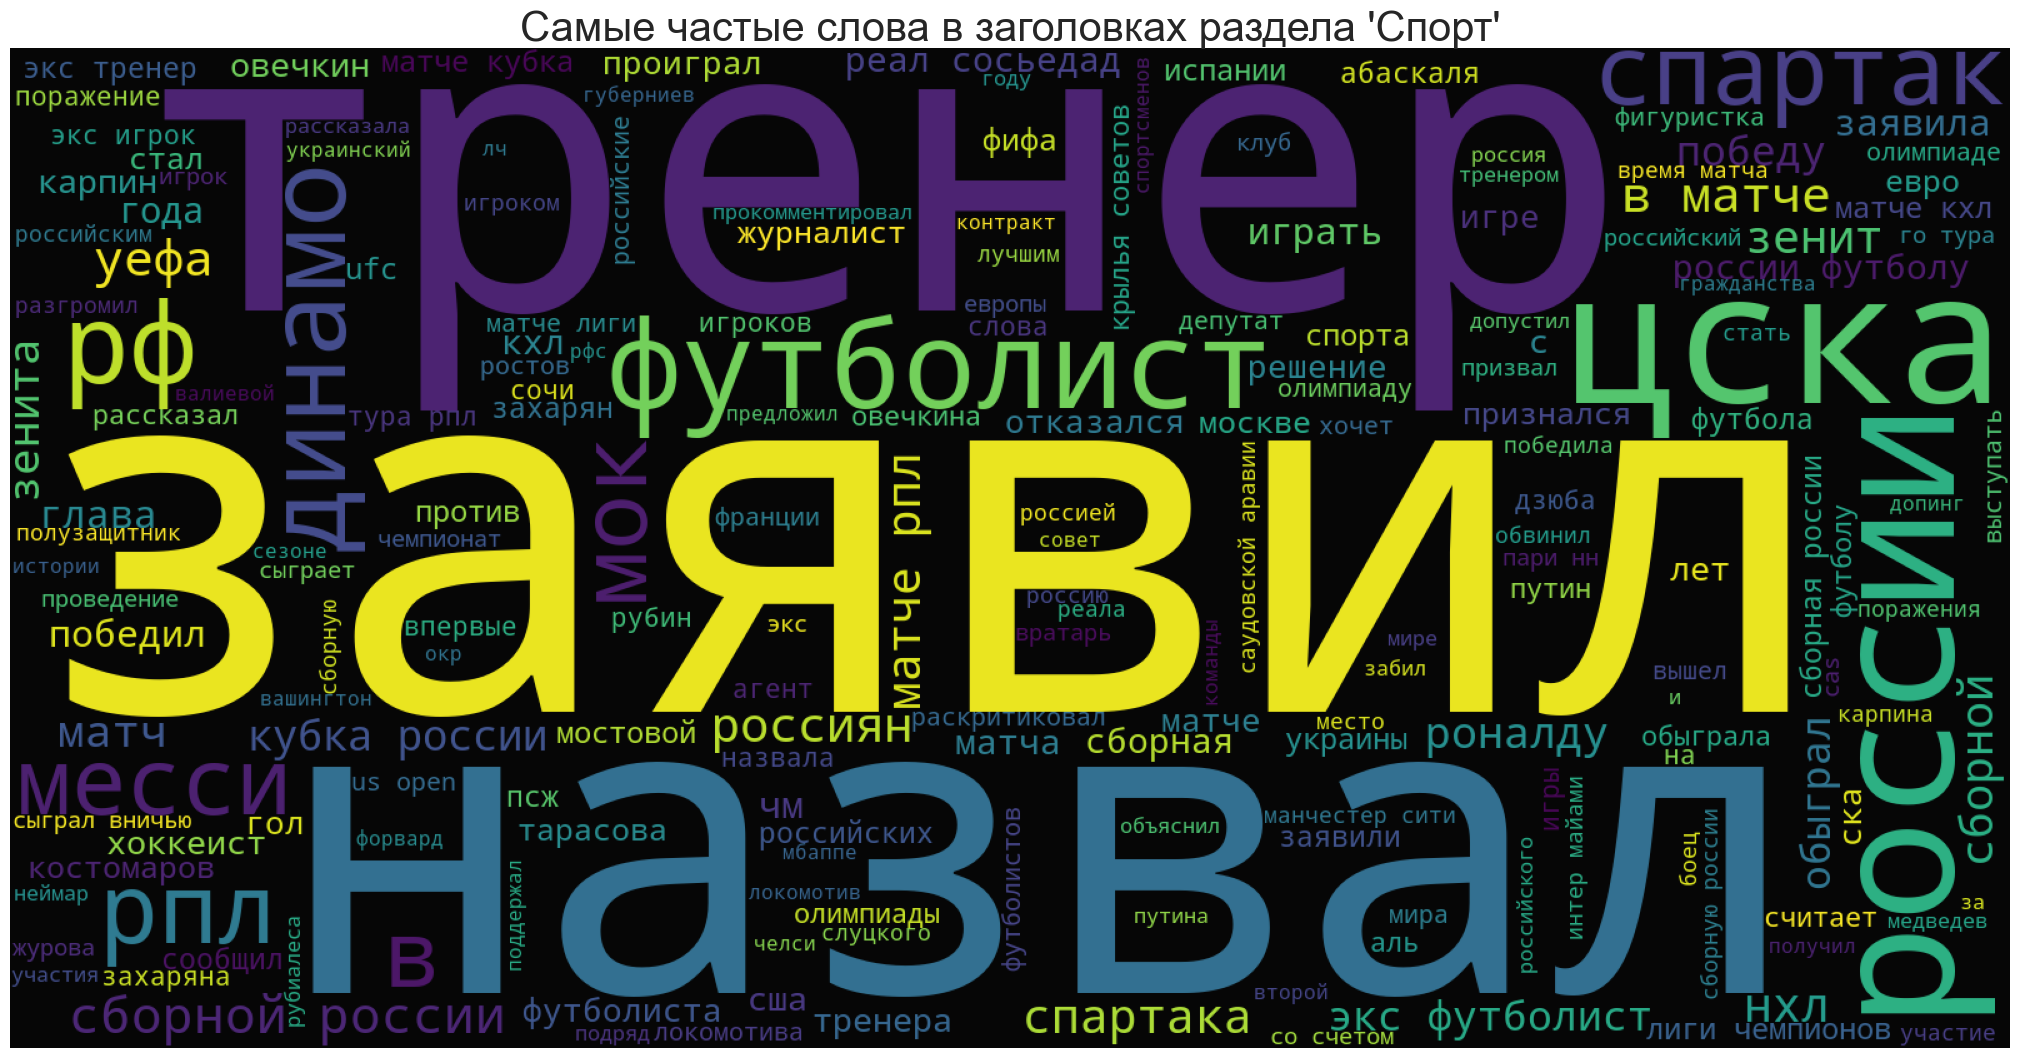

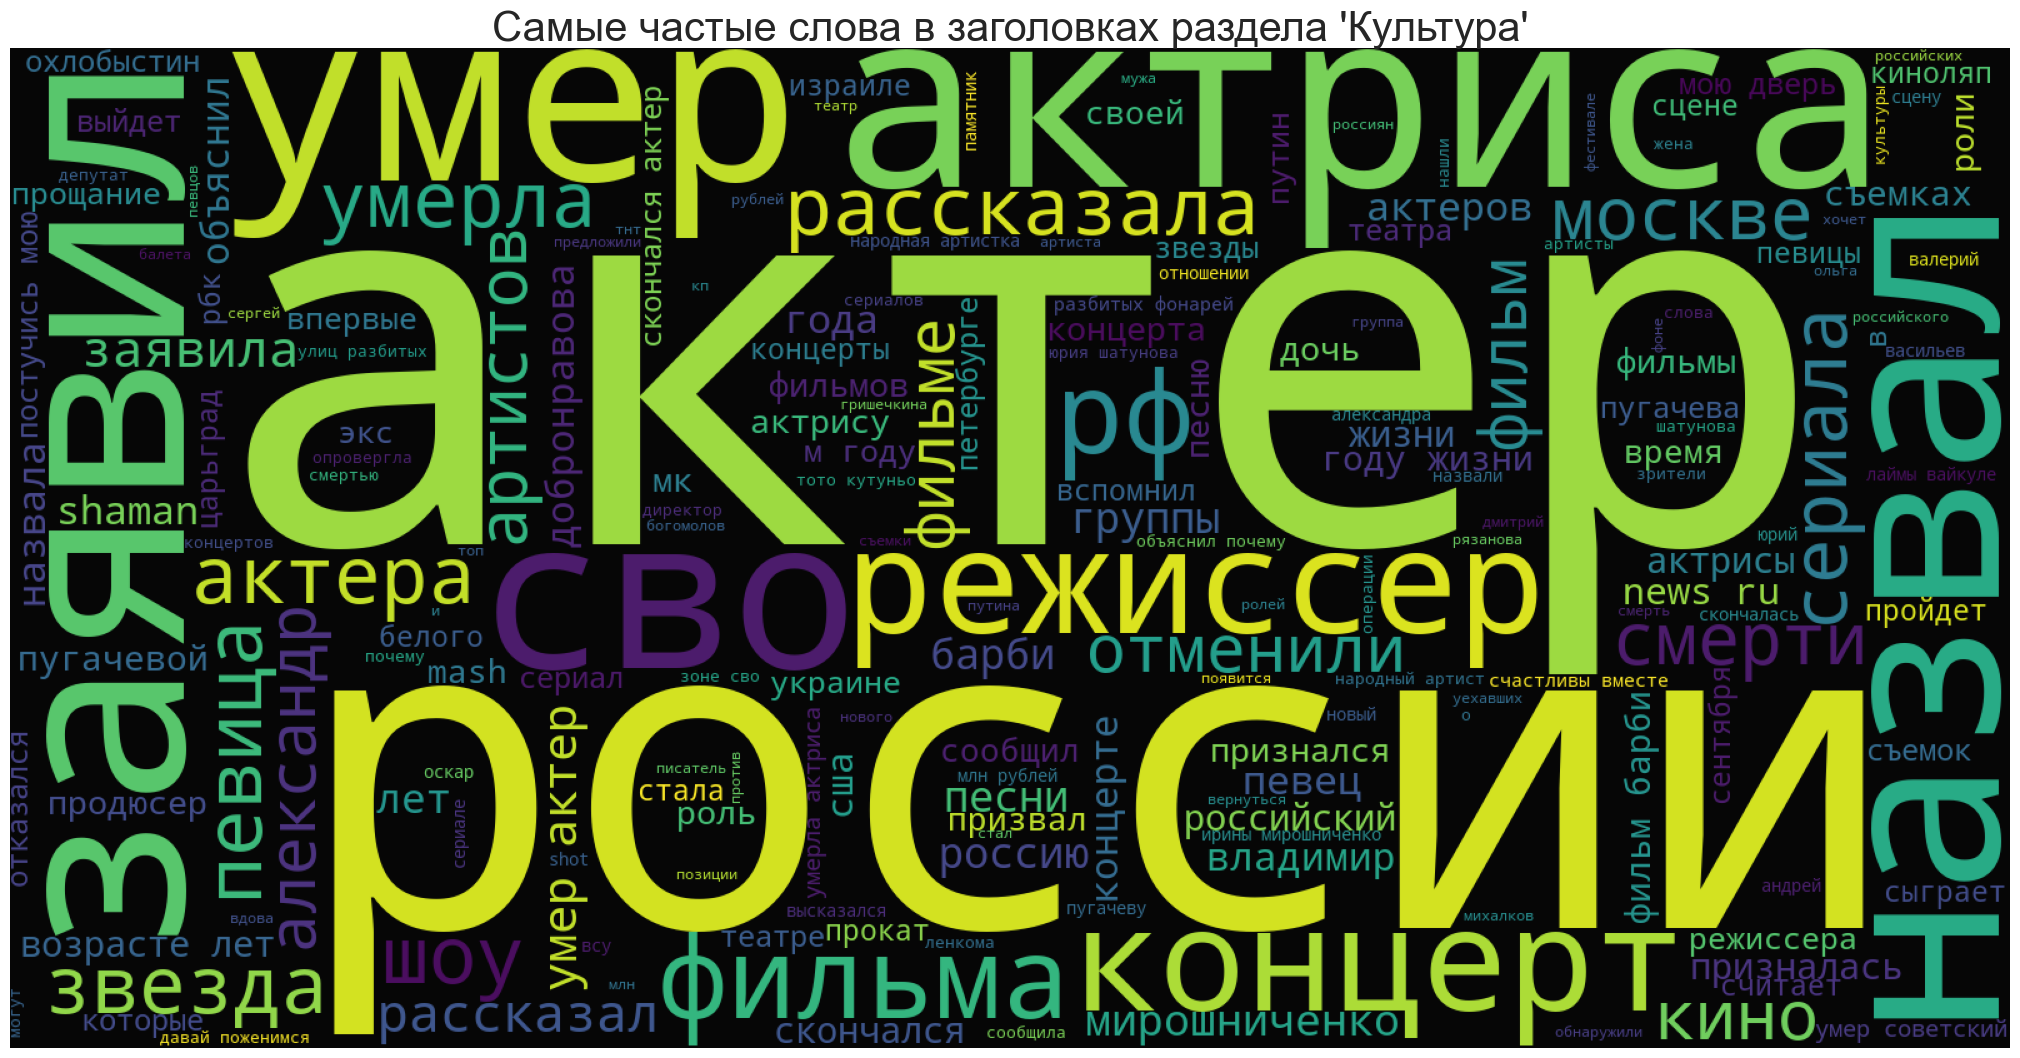

In [80]:
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Самые частые слова в заголовках раздела \'{topic}\'", fontsize=30)
    ax.imshow(wc, alpha=0.98)

## Промежуточный анализ

- Мы спарсили статьи с первых 100 страниц сайта osnmedia.ru и нам удалось извлечь 13.5 тысяч статей. СТатьи разделились по восьми категориям `Общество`, `Политика`, `Экономика`, `Происшествия`, `В мире`, `Спорт` и `Культура`. 
- Нам удалось подготовить датасет, в ходе чего мы очистили названия статей от ненужных символов, привели признак с датой к нужному формату. 
- Проводя разведочный анализ данных, мы создали новые признаки с днём недели и месяцем, в которые выпущены статьи. С помощью этого мы построили гистограмму, на которой выяснили, в какие месяцы ($ноябрь$) и дни недели($вторник и среда$) выпускалось больше всего статей. 
- Также мы проанализировали длины заголовков и самих статей и выяснили, что средней длиной статьи является 67 знаков, а средний размер статьи на сайте - 1251 знаков. 
- В заключении анализа, мы создали облака самых часто встречающихся в заголовках слов по каждому из разделов